In [ ]:
import os
import requests
import tarfile
import torch
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import pickle

In [ ]:
def download_cifar10(url, save_path):
    # Sending a GET request to the URL to start downloading the file
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    chunk_size = 1024
    with open(save_path, 'wb') as f:
        for data in response.iter_content(chunk_size=chunk_size):
            f.write(data)
            downloaded_size = os.path.getsize(save_path)
            progress = 100 * downloaded_size / total_size
            print('\rDownloading: {:.2f}%'.format(progress), end='', flush=True)
    print("\nDownload completed!")

# Download CIFAR-10 dataset
cifar10_url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
save_path = "./cifar-10-python.tar.gz"
download_cifar10(cifar10_url, save_path)

In [3]:
# Extracts the CIFAR-10 dataset from the tarball
def extract_cifar10(archive_path, extract_dir):
    with tarfile.open(archive_path, 'r:gz') as tar:
        tar.extractall(extract_dir)
    print("Extraction completed!")

archive_path = "/home/anwesh2410/Sem 4/PRML/Proj/seee//cifar-10-python.tar.gz"
extract_dir = "/home/anwesh2410/Sem 4/PRML/Proj/seee//cifar-10-python"
extract_cifar10(archive_path, extract_dir)

Extraction completed!


In [4]:
#converting the device to gpu
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [5]:
def load_cifar10(data_dir):
    images = []
    labels = []
    try:
        for file in os.listdir(data_dir):
            if file.startswith('data_batch') or file.startswith('test_batch'):
                with open(os.path.join(data_dir, file), 'rb') as fo:
                    cifar_data = pickle.load(fo, encoding='bytes')
                    for i, image_data in enumerate(cifar_data[b'data']):
                        # CIFAR-10 images are in CHW format (channels, height, width)
                        # Reshape the image to HWC format (height, width, channels)
                        image = np.transpose(np.reshape(image_data, (3, 32, 32)), (1, 2, 0))
                        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                        label = cifar_data[b'labels'][i]
                        images.append(image)
                        labels.append(label)
    except Exception as e:
        print("Error loading CIFAR-10 dataset:", e)
    return np.array(images), np.array(labels)


# Function to preprocess images
def preprocess_images(images):
    # Resize images to a fixed size (e.g., 32x32)
    resized_images = [cv2.resize(image, (64, 64)) for image in images]
    processed_images = np.array(resized_images, dtype=np.float32) / 255.0
    return processed_images

data_dir = 'cifar-10-python/cifar-10-batches-py'
images, labels = load_cifar10(data_dir)

processed_images = preprocess_images(images)

X_train, X_test, y_train, y_test = train_test_split(processed_images, labels, train_size=0.8, test_size=0.2, random_state=42)

n_classes = len(np.unique(y_train))

n_classes = len(np.unique(y_train))

print("Number of training samples:", len(X_train))
print("Number of test samples:", len(X_test))
print("Image shape:", X_train.shape)
print("Number of classes:", n_classes)

processed_images
labels

Number of training samples: 48000
Number of test samples: 12000
Image shape: (48000, 64, 64)
Number of classes: 10


array([1, 8, 5, ..., 1, 1, 5])

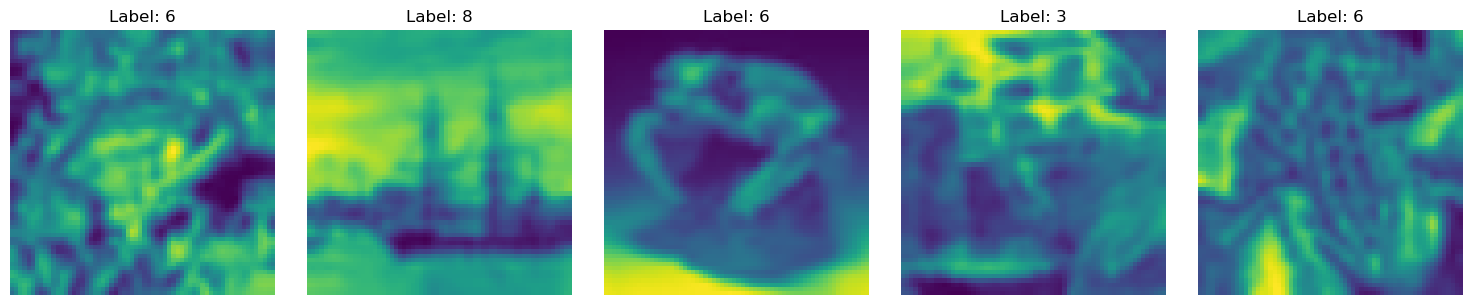

In [6]:
import matplotlib.pyplot as plt

def plot_images(images, labels, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        axes[i].imshow(images[i])
        axes[i].set_title("Label: {}".format(labels[i]))
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

plot_images(X_train[:5], y_train[:5])


In [7]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler

X_train_flat = X_train.reshape(len(X_train), -1)
X_test_flat = X_test.reshape(len(X_test), -1)

pca = PCA(n_components=150)
X_train_pca = pca.fit_transform(X_train_flat)
X_test_pca = pca.transform(X_test_flat)

lda = LinearDiscriminantAnalysis(n_components=n_classes-1)
X_train_lda = lda.fit_transform(X_train_flat, y_train)
X_test_lda = lda.transform(X_test_flat)


nb= GaussianNB()
nb.fit(X_train_flat, y_train)

lda = LinearDiscriminantAnalysis()
X_train_lda = lda.fit_transform(X_train_flat, y_train)
X_test_lda = lda.transform(X_test_flat)
nb_lda = GaussianNB()
nb_lda.fit(X_train_lda, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_pca)
X_test_scaled = scaler.transform(X_test_pca)
svm_clf = svm.SVC(kernel='rbf', gamma='scale', C=1.0)
svm_clf.fit(X_train_scaled, y_train)


SVC()

In [19]:
log_reg = LogisticRegression(max_iter=3000)
log_reg.fit(X_train_flat, y_train)

/home/anwesh2410/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=3000)

In [9]:

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_flat, y_train)

random_forest = RandomForestClassifier(n_estimators=200, random_state=42)
random_forest.fit(X_train_flat, y_train)

decision_tree = DecisionTreeClassifier(max_depth = 20, random_state=42)
decision_tree.fit(X_train_flat, y_train)

/home/anwesh2410/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DecisionTreeClassifier(max_depth=20, random_state=42)

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train_pca, y_train)

y_pred_pca = knn.predict(X_test_pca)

accuracy_pca = accuracy_score(y_test, y_pred_pca)
print("Accuracy on PCA-transformed test data:", accuracy_pca)


knn.fit(X_train_lda, y_train)

y_pred_lda = knn.predict(X_test_lda)

accuracy_lda = accuracy_score(y_test, y_pred_lda)
print("Accuracy on LDA-transformed test data:", accuracy_lda)


y_pred_nb = nb.predict(X_test_flat)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print("Naive Bayes Accuracy:", accuracy_nb)

y_pred_nb_lda = nb_lda.predict(X_test_lda)
accuracy_nb_lda = accuracy_score(y_test, y_pred_nb_lda)
print("Naive Bayes for LDA Accuracy:", accuracy_nb_lda)

y_pred = svm_clf.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("SVM Accuracy:", accuracy)

Accuracy on PCA-transformed test data: 0.32508333333333334
Accuracy on LDA-transformed test data: 0.21308333333333335
Naive Bayes Accuracy: 0.2653333333333333
Naive Bayes for LDA Accuracy: 0.23775
SVM Accuracy: 0.48125


In [20]:
y_pred = log_reg.predict(X_test_flat)

accuracy = accuracy_score(y_test, y_pred)
print("Logistic Regression Accuracy:", accuracy)

y_pred_rf = random_forest.predict(X_test_flat)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", accuracy_rf)

y_pred_dt = decision_tree.predict(X_test_flat)

accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Decision Tree Accuracy:", accuracy_dt)


Logistic Regression Accuracy: 0.29483333333333334
Random Forest Accuracy: 0.43775
Decision Tree Accuracy: 0.24366666666666667


In [29]:
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


class SimpleClassifier(nn.Module):

    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        self.flatten = nn.Flatten()
        # Initialize the modules we need to build the network
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.act_fn = nn.Tanh()
        self.linear2 = nn.Linear(num_hidden, num_outputs)

    def forward(self, x):
        # Perform the calculation of the model to determine the prediction
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.act_fn(x)
        x = self.linear2(x)
        return x

model = SimpleClassifier(num_inputs=4096, num_hidden=1000, num_outputs=10)
model.to(device)

BATCH_SIZE = 32

train_dataset = data.TensorDataset(torch.tensor(X_train_flat, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
train_data_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True)

X_train_pca_tensor = torch.tensor(X_train_pca)
y_train_tensor = torch.tensor(y_train)

train_dataset_pca = data.TensorDataset(X_train_pca_tensor, y_train_tensor)
train_dataloader_pca = DataLoader(train_dataset_pca, batch_size=BATCH_SIZE, shuffle=True)

loss_fn = nn.CrossEntropyLoss()

# Input to the optimizer are the parameters of the model: model.parameters()
optimizer = torch.optim.SGD(model.parameters(), lr=0.026)

def accuracy_fn(y_true, y_pred):
 
    correct = (y_true == y_pred).sum()

    # Calculate the accuracy
    accuracy = correct / len(y_true)

    return accuracy

def train_model(model, optimizer, data_loader, loss_fn, num_epochs=100):
    # Set model to train mode
    model.to(device)
    model.train()
    train_loss, train_acc = 0, 0

    # Training loop
    for epoch in tqdm(range(num_epochs)):
        for data_inputs, data_labels in data_loader:

            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs = data_inputs.to(device)
            data_inputs = data_inputs.to(torch.float32)
            data_labels = data_labels.to(device).to(torch.int64)
            
            
            ## Step 2: Run the model on the input data
            preds = model(data_inputs)
            y = data_labels
            loss = loss_fn(preds, y)
            train_loss += loss
            train_acc += accuracy_fn(y_true=y,y_pred=preds.argmax(dim=1))


            ## Step 3: Perform backpropagation
            # Before calculating the gradients, we need to ensure that they are all zero.
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad()
            # Perform backpropagation
            loss.backward()

            ## Step 4: Update the parameters
            optimizer.step()
    
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

train_model(model, optimizer, train_data_loader, loss_fn)

test_dataset = data.TensorDataset(torch.tensor(X_test_flat, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))
test_data_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=False)

X_test_pca_tensor = torch.tensor(X_test_pca)
y_test_tensor = torch.tensor(y_test)

test_dataset_pca = data.TensorDataset(X_test_pca_tensor, y_test_tensor)
test_dataloader_pca = DataLoader(test_dataset_pca, batch_size=BATCH_SIZE, shuffle=False)

def eval_model(model, data_loader):
    model.eval() # Set model to eval mode
    true_preds, num_preds = 0., 0.
    test_loss, test_acc = 0, 0

    with torch.no_grad(): # Deactivate gradients for the following code
        for data_inputs, data_labels in data_loader:

            # Determine prediction of model on dev set
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
            y = data_labels
            data_inputs = data_inputs.to(torch.float32)
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)
            preds = torch.sigmoid(preds) # Sigmoid to map predictions between 0 and 1
            test_loss += loss_fn(preds, y)
    
            test_acc += accuracy_fn(y_true=y,y_pred=preds.argmax(dim=1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc*100:.2f}%\n") 
    

eval_model(model, test_data_loader)

  0%|          | 0/100 [00:00<?, ?it/s]

Test loss: 2.03186 | Test accuracy: 44.53%



In [23]:
class ObjectRecognition(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, hidden_units1: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(in_features=hidden_units, out_features=hidden_units1),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(in_features=hidden_units1, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = x.to(torch.float32)
        return self.layer_stack(x)

    
model_1 = ObjectRecognition(input_shape=150, hidden_units=256,hidden_units1=128, output_shape=10)
model_1.to(device)
 

model_2 = ObjectRecognition(input_shape=4096, hidden_units=1024,hidden_units1=512, output_shape=10)
model_2.to(device)



ObjectRecognition(
  (layer_stack): Sequential(
    (0): Linear(in_features=4096, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [41]:
optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=0.10)
optimizer_1 = torch.optim.Adam(model_1.parameters(), lr=0.001) 

In [38]:
epochs = 1
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    
    train_model(model=model_1,optimizer=optimizer_1,data_loader=train_dataloader_pca,loss_fn=loss_fn)
    
    eval_model(model=model_1,data_loader=test_dataloader_pca)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 0
---------


  0%|          | 0/100 [00:00<?, ?it/s]

Test loss: 2.29307 | Test accuracy: 29.49%



In [42]:
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    
    train_model(model=model_2,optimizer=optimizer_2,data_loader=train_data_loader,loss_fn=loss_fn)
    
    eval_model(model=model_2,data_loader=test_data_loader)

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 0
---------


  0%|          | 0/100 [00:00<?, ?it/s]

Test loss: 2.30258 | Test accuracy: 10.27%

